# Profiling bacterial abundance with Kraken2 and Bracken

## Preamble

In [1]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [78]:
# Matplotlib config
import os
from matplotlib import font_manager
from pathlib import Path

figures_dir = Path('/u/thosi/dev/projects/bifido_summary/report/figures')

for font_file in font_manager.findSystemFonts(
    fontpaths=f'{os.environ['GROUP_HOME']}/fonts'
):
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

## What are the observed taxa abundances for Bifido-labeled samples?

In [3]:
bracken_db = '/ptmp/thosi/bifido_summary/results/abundance.duckdb'

query = 'select "sample", "name", fraction_total_reads from abundance where fraction_total_reads > .05;'

with duckdb.connect(database=bracken_db, read_only=True) as con:
    bracken = con.sql(query).df()

In [4]:
samplesheet_db = '/ptmp/thosi/bifido_summary/results/samplesheet.duckdb'

query = 'select "sample", ID, taxon, relationship, time_weeks from samplesheet;'

with duckdb.connect(database=samplesheet_db, read_only=True) as con:
    samplesheet = con.sql(query).df()

In [34]:
bifido_bracken = (
    bracken
    .assign(sample=lambda df: df.pop('sample').astype(int))
    .merge(samplesheet)
    .pivot_table(
        index=['ID', 'taxon'],
        columns='name',
        values='fraction_total_reads',
        observed=False
    )
    .sort_values([
        'Bifidobacterium bifidum',
        'Bifidobacterium longum',
        'Bifidobacterium adolescentis',
    ], ascending=False)
)

In [35]:
# Plot obs from Bifido or others with high obs. bifido
obs_mask = bifido_bracken.filter(like='Bifido').count(axis=1) > 0
label_mask = bifido_bracken.index.get_level_values('taxon').str.contains('Bifido')
bifido_bracken_filt = bifido_bracken[obs_mask | label_mask].dropna(how='all', axis=1)

# Sample info for plots
taxa = bifido_bracken_filt.columns
samples = bifido_bracken_filt.index.get_level_values('ID')

# Data for plot 1 heatmap
plate_labels = (bifido_bracken_filt.index.get_level_values('taxon').astype(str).values == 'Bifidobacterium_spp').reshape(-1, 1)

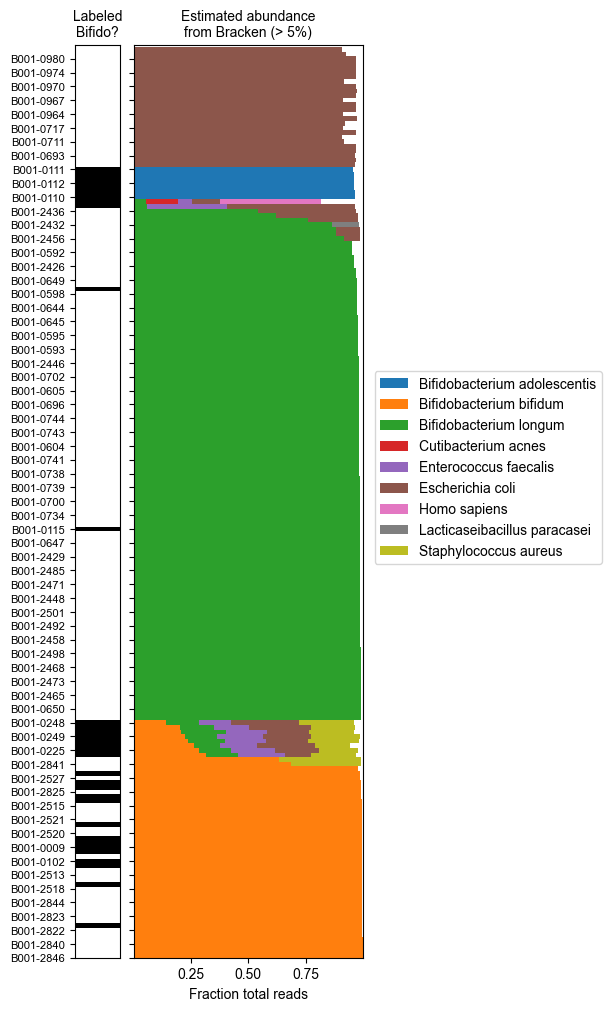

In [80]:
fig, axs = plt.subplots(
    1, 2,
    figsize=(6, 10),
    gridspec_kw={'width_ratios': [1, 5]},
    layout='constrained',
    sharey=True
)

ax = axs[0]
ax.imshow(plate_labels, aspect='auto', cmap='Greys_r')
ax.set_xticks([])
ax.set_ylim(0, y_max)
# ax.set_ylabel('Samples with detected Bifido > 5% (n=172)')
ax.set_yticks(
    y_vals[::3],
    samples[::3],
    fontsize=8
)
ax.set_title('Labeled\nBifido?', fontsize=10)

ax = axs[1]

y_max = bifido_bracken_filt.shape[0]
y_vals = range(y_max)
x_left = None

for taxon in taxa:
    pltdata = bifido_bracken_filt[taxon].fillna(0)
    ax.barh(y_vals, pltdata, label=taxon, height=1, left=x_left)
    if x_left is not None:
        x_left = x_left + pltdata.values
    else:
        x_left = pltdata.values

ax.set_xlim(0, 1)
ax.set_xlabel('Fraction total reads')
ax.set_xticks([.25, .5, .75])
ax.set_title('Estimated abundance\nfrom Bracken (> 5%)', fontsize=10)
ax.legend(bbox_to_anchor=(1.02, .65))

for ext in ['pdf', 'png']:
    fig.savefig(figures_dir / f'abundance_est.{ext}', bbox_inches='tight')